In [24]:
from qiskit.visualization import plot_histogram
from qiskit import Aer, QuantumCircuit, execute, QuantumRegister, ClassicalRegister, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
import numpy as np

In [25]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [26]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

In [27]:
def xor(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

In [28]:
def sudoku_oracle(qc, clause_list, clause_qubits):
    # Use XOR gate to check each clause
    i = 0
    for clause in clause_list:
        xor(qc, clause[0], clause[1], clause_qubits[i])
        i += 1
    qc.mct(clause_qubits, output_qubit)
    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        xor(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

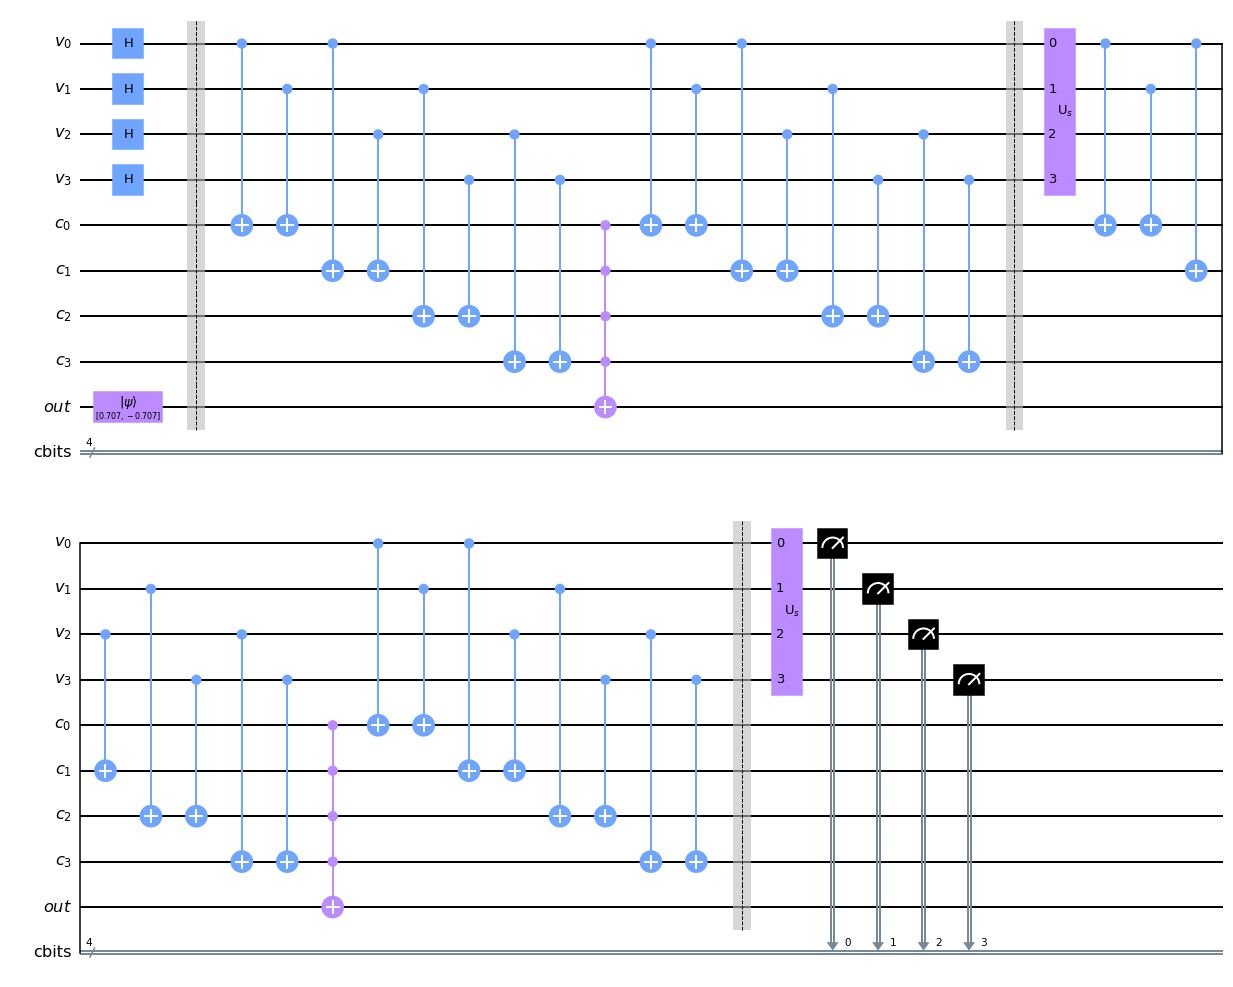

In [29]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
sudoku = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
sudoku.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
sudoku.h(var_qubits)
sudoku.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(sudoku, clause_list, clause_qubits)
sudoku.barrier()  # for visual separation
# Apply our diffuser
sudoku.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(sudoku, clause_list, clause_qubits)
sudoku.barrier()  # for visual separation
# Apply our diffuser
sudoku.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
sudoku.measure(var_qubits, cbits)

sudoku.draw('mpl')

In [30]:
simulator = Aer.get_backend('aer_simulator')
result = execute(sudoku, backend=simulator, shots=1024).result()
counts = result.get_counts()

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
devices = provider.backends(n_qubits=9, operational=True, simulator=True)
device = least_busy(devices)

In [ ]:
job = execute(sudoku, backend=device, shots=1024)
print(job.job_id())
job_monitor(job)

In [ ]:
result = job.result()
device_counts = result.get_counts()

In [ ]:
plot_histogram([counts, device_counts])